# Explanations of machine learning models using CAM-based methods

In this tutorial you are going to examine how to use the CAM-based explanations to evaluate your ML model.

We begin by introducing the fundamental blocks used to perform an explanation on a single image:

This example corresponds to the one from the official tutorial and is used for demonstration purposes

In [1]:
!pip install grad-cam
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 16.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=4fc7e5764da0a6c3ffd6f82bf8c45fa666eccb575f4853b614e88507e906c980
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.1 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=7033d48a4ce739db55e67d66de2d2c67b1a47f89ebb052256cd5d6c2250eeded
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully bu

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([1, 3, 224, 224])
(224, 672, 3)


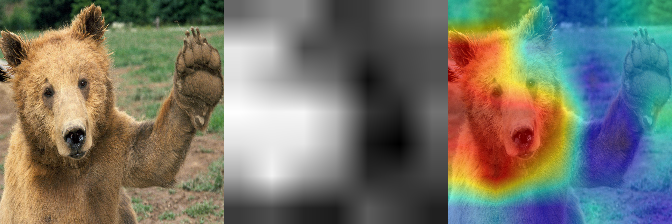

In [2]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    print(input_tensor.shape)
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images1 = np.hstack((np.uint8(255*img), cam , cam_image))
print(images1.shape)
Image.fromarray(images1)

## Things to note down:

- You can change the model (any model from torchvision.models is typically fine)
- You can change the target layer (i.e. the layer which generates the predictions), but it recommended that you use the final convolutional layer 
- If you do not specify the target class, then the explainer is going to select the most likely class (i.e. the class with the highest prediction confidence)

The confidence increase percent: 0.005073717329651117
The visualization of the pertubated image for the metric:


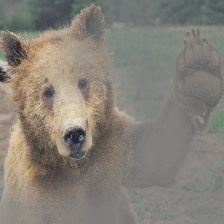

In [3]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Benchmarking CAMs

You can use the existing benchmark method in your implementation if you wish, but it is here purely as an example of how to use different CAM attribution methods

100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


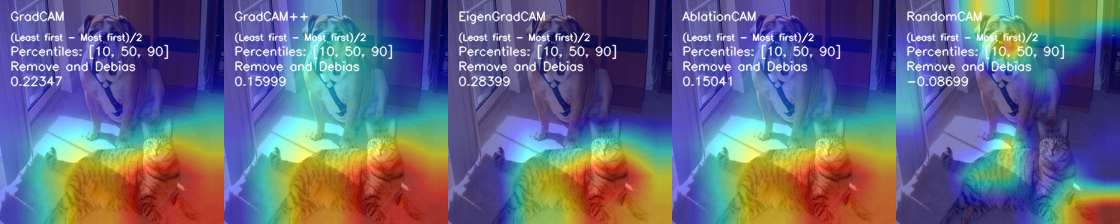

In [4]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, use_cuda=True))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## This section shows you how to load the MedMNIST dataset

In [6]:
import medmnist
import torch
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda

# preprocessing
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load the data; you are free to choose the dataset yourself, but beware that not all of 
# them are compatible with the standard torchvision models
data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
val_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
print('Test set size: ', len(train_set), '\n',
      'Val set size: ', len(val_set), '\n',
      'Test set size:', len(test_set))
# You are expected to create the appropriate dataloaders to be used for training, testing and validation 
# We propose a 70-15-15 split, but this is entirely up to you

### YOUR CODE BELOW ###
from torch.utils.data import DataLoader
from argparse import Namespace
from torchvision.models.resnet import ResNet, BasicBlock

config = Namespace()
config.batch_size = 128
config.num_workers = 2
config.seed = 0
config.device = "cuda" if torch.cuda.is_available() else "cpu"
        
model = models.resnet18()
train_loader = DataLoader(dataset=train_set, batch_size=config.batch_size, num_workers=config.num_workers, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=config.batch_size, num_workers=config.num_workers, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=config.batch_size, num_workers=config.num_workers, shuffle=False)

  0%|          | 0/4170669 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Test set size:  4708 
 Val set size:  524 
 Test set size: 624


In [ ]:
# from torchvision.models.resnet import ResNet, BasicBlock
# class MnistResNet(ResNet):
#     def __init__(self):
#         super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=4)
#         self.conv1 = torch.nn.Conv2d(1, 64, 
#             kernel_size=(7, 7), 
#             stride=(2, 2), 
#             padding=(3, 3), bias=False)
# model = MnistResNet()

### Data visulaization

In [ ]:
train_set

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

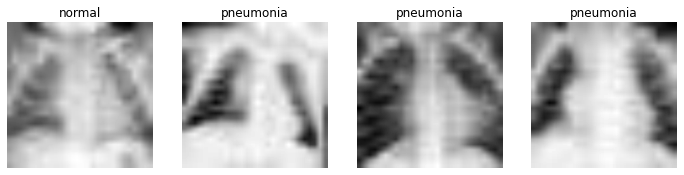

In [12]:
import matplotlib.pyplot as plt

labels_map = {0: 'normal',
              1: 'pneumonia'}
figure = plt.figure(figsize=(12, 12))
cols = 4
for i in range(1, cols + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(1, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img[0].squeeze(), cmap="gray")
plt.show()

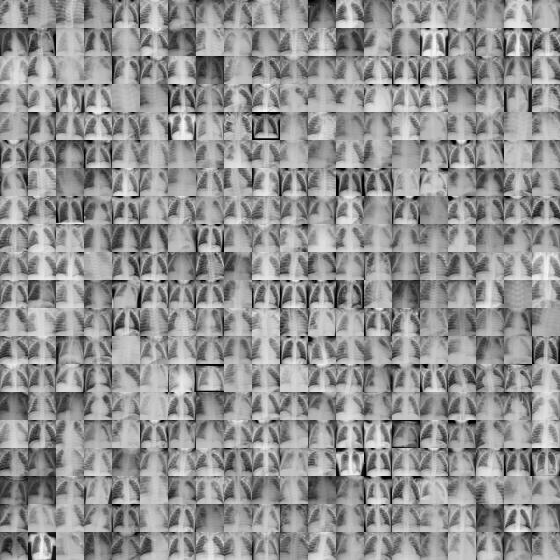

In [13]:
train_set.montage(length=20)

torch.Size([1, 3, 224, 224]) (224, 224, 3)


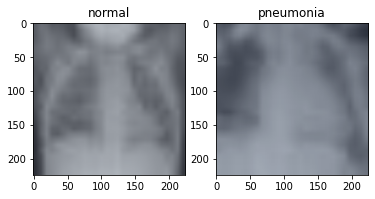

In [14]:
img_normal, label_normal = val_set[np.where(val_set.labels == 0)[0][0]]
img_pneum, label_pneum = val_set[np.where(val_set.labels == 1)[0][0]]
img_normal_tensor, img_pneum_tensor = img_normal.unsqueeze(0), img_pneum.unsqueeze(0)
img_normal, img_pneum = np.float32(deprocess_image(img_normal.permute(1,2,0).numpy())) / 255, np.float32(deprocess_image(img_pneum.permute(1,2,0).numpy())) / 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img_normal)
ax1.set_title(labels_map[label_normal])

ax2.imshow(img_pneum)
ax2.set_title(labels_map[label_pneum])

print(img_normal_tensor.shape, img_normal.shape)

### Model training

Now that you have loaded the model and the dataset, you can proceed to training it
We provide you with a sample training loop, you are allowed to modify it as you please

Your goal here is to add the explanations to either the validation or the testing loop 
It is entirely up to you how to achieve this; the main goal of the exercise is to observe how 
the explanations change over the course of training.

Hint: you may want to run the explainer on the untrained model to get a baseline 'random' prediction

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# You are expected to save the models during training 
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###
saved_models = None



def train(device, model, train_loader, epochs, learning_rate):
  
    images_normal = np.uint8(255*img_normal)
    images_pneum = np.uint8(255*img_pneum)

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []

        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')): 
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')): 
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target)
                valid_losses.append(loss.item())
        
        
        # We suggest you modify this code to run the continuous explanations
        print(f"Grad-cam testing")
        target_layers = [model.layer4]
        targets_normal = [ClassifierOutputSoftmaxTarget(0)]
        targets_pneum = [ClassifierOutputSoftmaxTarget(1)]

        with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
            grayscale_cams_normal = cam(input_tensor=img_normal_tensor, targets=targets_normal, aug_smooth=True, eigen_smooth=True)
            grayscale_cams_pneum = cam(input_tensor=img_pneum_tensor, targets=targets_pneum, aug_smooth=True, eigen_smooth=True)
            cam_image_normal = show_cam_on_image(img_normal, grayscale_cams_normal[0, :], use_rgb=True)
            cam_image_normal = cv2.putText(cam_image_normal, f'Epoch:{epoch+1}', (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cam_image_pneum = show_cam_on_image(img_pneum, grayscale_cams_pneum[0, :], use_rgb=True)
            cam_image_pneum = cv2.putText(cam_image_pneum, f'Epoch:{epoch+1}', (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            images_normal = np.hstack((images_normal, cam_image_normal))
            images_pneum = np.hstack((images_pneum, cam_image_pneum))
        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )
    return model, Image.fromarray(images_normal), Image.fromarray(images_pneum)

In [ ]:
model, Im_norm, Im_pneum = train(device=config.device, model=model, train_loader=train_loader, epochs=15, learning_rate=0.0001)
PATH = '/content/drive/MyDrive/AI in Med/practical_3/model_state_dict.pth'
torch.save(model.state_dict(), PATH)

Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


Grad-cam testing
Train Epoch: 1 Loss: 0.110402 Validation loss: 0.089010 Acc: 96.085304 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


Grad-cam testing
Train Epoch: 2 Loss: 1.507707 Validation loss: 0.176554 Acc: 84.103885 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


Grad-cam testing
Train Epoch: 3 Loss: 0.161357 Validation loss: 0.116673 Acc: 94.073480 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]


Grad-cam testing
Train Epoch: 4 Loss: 0.118873 Validation loss: 0.090585 Acc: 95.325169 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


Grad-cam testing
Train Epoch: 5 Loss: 0.106708 Validation loss: 0.077708 Acc: 95.964527 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


Grad-cam testing
Train Epoch: 6 Loss: 0.107396 Validation loss: 0.079462 Acc: 95.647804 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]


Grad-cam testing
Train Epoch: 7 Loss: 0.103287 Validation loss: 0.086782 Acc: 96.139358 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


Grad-cam testing
Train Epoch: 8 Loss: 0.100925 Validation loss: 0.073981 Acc: 96.229730 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Grad-cam testing
Train Epoch: 9 Loss: 0.097353 Validation loss: 0.073638 Acc: 96.314189 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


Grad-cam testing
Train Epoch: 10 Loss: 0.084047 Validation loss: 0.064724 Acc: 96.751689 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Grad-cam testing
Train Epoch: 11 Loss: 0.077546 Validation loss: 0.061435 Acc: 97.053209 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


Grad-cam testing
Train Epoch: 12 Loss: 0.094059 Validation loss: 0.061014 Acc: 96.573480 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


Grad-cam testing
Train Epoch: 13 Loss: 0.072418 Validation loss: 0.057186 Acc: 97.276182 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


Grad-cam testing
Train Epoch: 14 Loss: 0.082133 Validation loss: 0.062591 Acc: 96.799831 


Validation-loop: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]


Grad-cam testing
Train Epoch: 15 Loss: 0.066842 Validation loss: 0.054171 Acc: 97.460304 


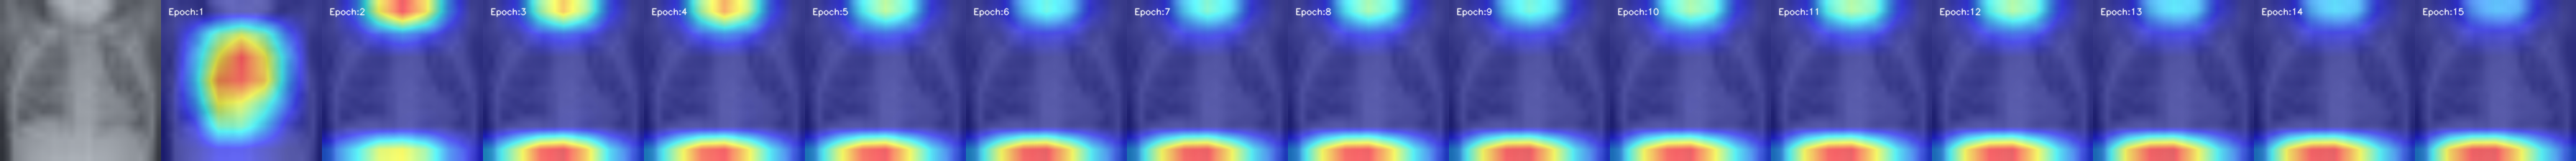

In [ ]:
Im_norm

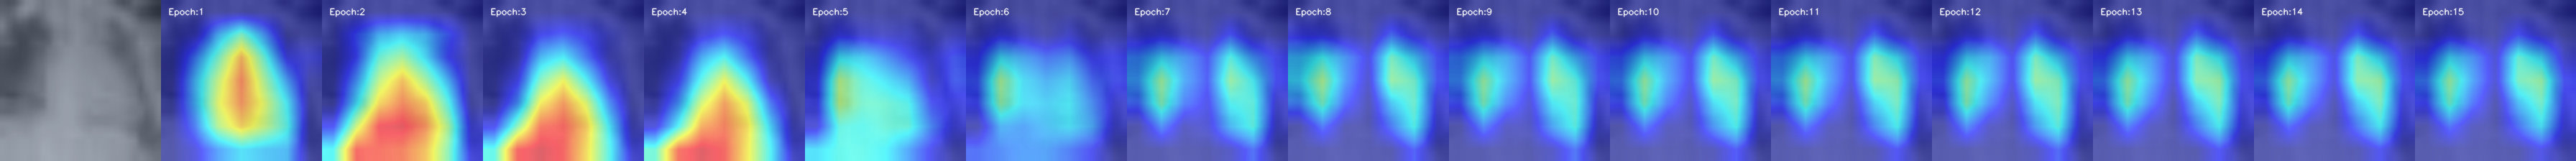

In [ ]:
Im_pneum

In [16]:
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage, ROADLeastRelevantFirstAverage

def benchmark(model, input_tensor, img, target_layers, method, eigen_smooth=False, aug_smooth=False, category=0):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, use_cuda=True))]
    input_tensor = input_tensor.cuda()
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    visualizations = []
    scores = []

    # 1st method: 
    if method == 'CamMultImageConfidenceChange':
        cam_metric = CamMultImageConfidenceChange() 
        drop = []
        rise = []
        for name, cam_method in methods:
            with cam_method:
                attributions = cam_method(input_tensor=input_tensor, 
                                          targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
                attribution = attributions[0, :]
           
                score, visualization = cam_metric(input_tensor, attributions, metric_targets, model, return_visualization=True)
                visualization = visualization[0].cpu().numpy().transpose((1, 2, 0))
                visualization = deprocess_image(visualization)
                visualizations.append(visualization)
                scores.append(score[0] * 100)
                drop.append(DropInConfidence()(input_tensor, attribution, metric_targets, model))
                rise.append(IncreaseInConfidence()(input_tensor, attribution, metric_targets, model))
        fig, axx = plt.subplots(1, 5, figsize=(20, 5))
        fig.suptitle(f'Confidence change for {category} category', fontsize=20)
        for i in range(len(scores)):
            axx[i].imshow(visualizations[i])
            axx[i].set_title('{}, score:{:.4f}'.format(methods[i][0], scores[i]), fontsize=12)
            axx[i].set_xlabel(f'drop:{drop[i]}, rise:{rise[i]}')

    # 2nd method
    elif method == 'ROAD_most':
        cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
        print(f'\nAnalysis for {category} category')
        print('---------------------------------')
        for name, cam_method in methods:
            with cam_method:
                attributions = cam_method(input_tensor=input_tensor, 
                                          targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
                score = cam_metric(input_tensor, attributions, targets, model)
                scores.append(score[0])
                print(f"{name}, Most relevant first avg confidence increase with ROAD accross 4 thresholds: {scores[0]}")
   
    # 3rd method
    elif method == 'ROAD_least':
        cam_metric = ROADLeastRelevantFirstAverage(percentiles=[20, 40, 60, 80])
        print(f'\nAnalysis for {category} category')
        print('---------------------------------')
        for name, cam_method in methods:
            with cam_method:
                attributions = cam_method(input_tensor=input_tensor, 
                                          targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
                score = cam_metric(input_tensor, attributions, targets, model)
                scores.append(score[0])
                print(f"{name}, Least relevant first avg confidence increase with ROAD accross 4 thresholds: {score[0]}")
    
    # 4th method
    elif method == 'ROAD_comb':
        percentiles = [20, 40, 60, 80]
        cam_metric = ROADCombined(percentiles=percentiles)
        for name, cam_method in methods:
            with cam_method:
                attributions = cam_method(input_tensor=input_tensor, 
                                          targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
                attribution = attributions[0, :]
                scores = cam_metric(input_tensor, attributions, metric_targets, model)
                score = scores[0]
                visualization = show_cam_on_image(img, attribution, use_rgb=True)
                visualization = visualize_score(visualization, score, name, percentiles)
                visualizations.append(visualization)
                
        return Image.fromarray(np.hstack(visualizations))

    return visualizations

def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "ROAD combined", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 60), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 80), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    
    return visualization    

In [17]:
def test(device, model, data_loader, method, mean=0.5432, std=0.2731):
    model.eval()
    preds = []
    pred_list = []
    correct = 0

    with torch.no_grad():
        for index, (image, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            image = image.to(device)
            target = target

            output = model(image).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    print(f"Grad-cam testing")
    target_layers = [model.layer4]
    cam_metric = CamMultImageConfidenceChange()
    Im_norm_score = benchmark(model=model,
                                    input_tensor=img_normal_tensor,
                                    img=img_normal, 
                                    target_layers=target_layers,
                                    method=method,
                                    eigen_smooth=True, aug_smooth=True,
                                    category=0)
    
    Im_pneum_score = benchmark(model=model,
                                    input_tensor=img_pneum_tensor,
                                    img=img_pneum, 
                                    target_layers=target_layers,
                                    method=method,
                                    eigen_smooth=True, aug_smooth=True,
                                    category=1)

    return np.concatenate(pred_list), Im_norm_score, Im_pneum_score

In [18]:
model.to(config.device)
PATH = '/content/drive/MyDrive/AI in Med/practical_3/model_state_dict.pth'
model.load_state_dict(torch.load(PATH, map_location=config.device))


<All keys matched successfully>

### 1st method: CAM and image multiplication, confidence score

Test-loop: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


Test Accuracy: 85.576923
Grad-cam testing


100%|██████████| 16/16 [00:00<00:00, 40.77it/s]


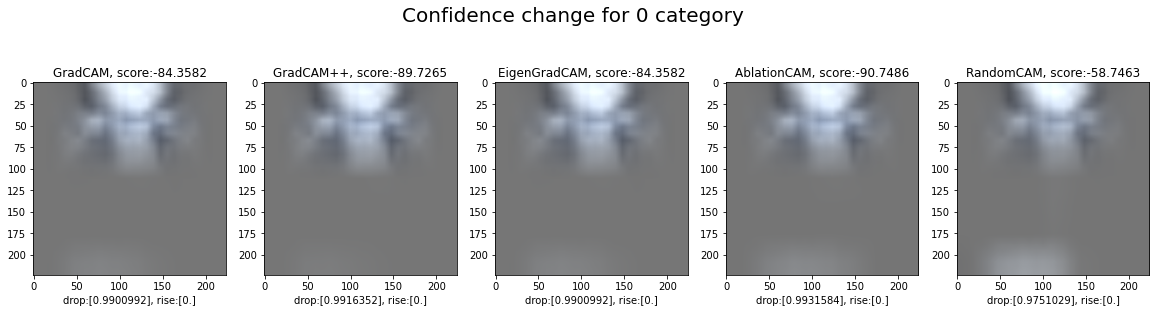

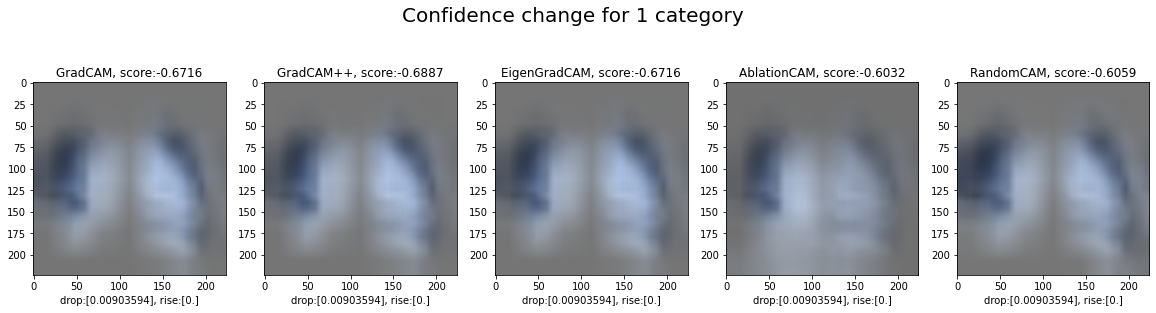

In [19]:
pred, Im1, Im2 = test(device=config.device, model=model, data_loader=test_loader, method='CamMultImageConfidenceChange')

### 2nd method: Remove and debias, Most Relevant First

In [20]:
pred, Im1, Im2 = test(device=config.device, model=model, data_loader=test_loader, method='ROAD_most')

Test-loop: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


Test Accuracy: 85.576923
Grad-cam testing

Analysis for 0 category
---------------------------------
GradCAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -15.299151420593262
GradCAM++, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -15.299151420593262
EigenGradCAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -15.299151420593262


100%|██████████| 16/16 [00:00<00:00, 40.84it/s]


AblationCAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -15.299151420593262
RandomCAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -15.299151420593262

Analysis for 1 category
---------------------------------
GradCAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -1.027602195739746
GradCAM++, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -1.027602195739746
EigenGradCAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -1.027602195739746


100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


AblationCAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -1.027602195739746
RandomCAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: -1.027602195739746


###3rd method: Remove and debias, Least Relevant First

In [21]:
pred, Im1, Im2 = test(device=config.device, model=model, data_loader=test_loader, method='ROAD_least')

Test-loop: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Test Accuracy: 85.576923
Grad-cam testing

Analysis for 0 category
---------------------------------
GradCAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: -2.250715732574463
GradCAM++, Least relevant first avg confidence increase with ROAD accross 4 thresholds: -2.131260395050049
EigenGradCAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: -2.2345385551452637


100%|██████████| 16/16 [00:00<00:00, 39.81it/s]


AblationCAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: -2.2901082038879395
RandomCAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: -3.1400370597839355

Analysis for 1 category
---------------------------------
GradCAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: 0.028867006301879883
GradCAM++, Least relevant first avg confidence increase with ROAD accross 4 thresholds: 0.028361082077026367
EigenGradCAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: 0.031055212020874023


100%|██████████| 16/16 [00:00<00:00, 40.85it/s]


AblationCAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: -0.05759024620056152
RandomCAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: 0.2164006233215332


### 4th method: Remove and debias combined:
\(Least Relevant First - Most Relevant First) / 2

In [22]:
pred, Im1, Im2 = test(device=config.device, model=model, data_loader=test_loader, method='ROAD_comb')

Test-loop: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


Test Accuracy: 85.576923
Grad-cam testing


100%|██████████| 16/16 [00:00<00:00, 40.03it/s]


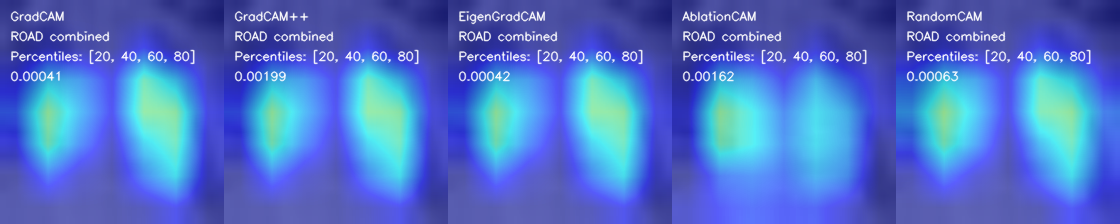

In [23]:
Im2